# Run temperature attributions and save out

1. Run one scenario emissions driven. Save out the following forcing categories:

- All forcing
- All minus GHGs
- All minus aerosols
- All minus other anthropogenic
- All minus natural
- All minus anthropogenic

2. re-run forcing-driven scenarios with the above.

In [1]:
import logging
import os

from fair import FAIR
from fair.interface import fill, initialise
from fair.io import read_properties
import matplotlib.pyplot as pl
import numpy as np
import pandas as pd
import scipy.stats
import xarray as xr

In [2]:
logger = logging.getLogger('fair')
logger.setLevel(level=logging.CRITICAL)

In [3]:
pl.style.use('../defaults.mplstyle')

In [4]:
output_ensemble_size=841

In [5]:
scenarios = ["all"]

In [6]:
f = FAIR()
f.define_time(1750, 2024, 1)
f.define_scenarios(scenarios)
species, properties = read_properties('../data/calibration/v1.4.1/species_configs_properties_1.4.1.csv')
f.define_species(species, properties)
f.ch4_method='Thornhill2021'
df_configs = pd.read_csv('../data/calibration/v1.4.1/calibrated_constrained_parameters_1.4.1.csv', index_col=0)
f.define_configs(df_configs.index)
f.allocate()

## First, emissions-driven run

### Get emissions and forcing into fair

We use the 2022 harmonization of historical emissions from Smith et al. (2024), plus a one-year extension to 2023 under the proposed ScenarioMIP "medium" pathway.

In [7]:
f.fill_from_csv(
    emissions_file='../data/emissions/v1.4.1/historical_1750-2023.csv',
    forcing_file='../data/forcing/v1.4.1/volcanic_solar.csv',
)

In [8]:
f.emissions

<xarray.DataArray (timepoints: 274, scenario: 1, config: 841, specie: 61)> Size: 112MB
array([[[[9.30608400e-03, 1.09921740e-02,            nan, ...,
                     nan,            nan,            nan],
         [9.30608400e-03, 1.09921740e-02,            nan, ...,
                     nan,            nan,            nan],
         [9.30608400e-03, 1.09921740e-02,            nan, ...,
                     nan,            nan,            nan],
         ...,
         [9.30608400e-03, 1.09921740e-02,            nan, ...,
                     nan,            nan,            nan],
         [9.30608400e-03, 1.09921740e-02,            nan, ...,
                     nan,            nan,            nan],
         [9.30608400e-03, 1.09921740e-02,            nan, ...,
                     nan,            nan,            nan]]],


       [[[9.40737800e-03, 3.29765220e-02,            nan, ...,
                     nan,            nan,            nan],
         [9.40737800e-03, 3.29765220e-02,            nan, ...,
                     nan,            nan,            nan],
         [9.40737800e-03, 3.29765220e-02,            nan, ...,
...
                     nan,            nan,            nan],
         [3.71503723e+01, 4.31001915e+00,            nan, ...,
                     nan,            nan,            nan],
         [3.71503723e+01, 4.31001915e+00,            nan, ...,
                     nan,            nan,            nan]]],


       [[[3.73769759e+01, 4.26344979e+00,            nan, ...,
                     nan,            nan,            nan],
         [3.73769759e+01, 4.26344979e+00,            nan, ...,
                     nan,            nan,            nan],
         [3.73769759e+01, 4.26344979e+00,            nan, ...,
                     nan,            nan,            nan],
         ...,
         [3.73769759e+01, 4.26344979e+00,            nan, ...,
                     nan,            nan,            nan],
         [3.73769759e+01, 4.26344979e+00,            nan, ...,
                     nan,            nan,            nan],
         [3.73769759e+01, 4.26344979e+00,            nan, ...,
                     nan,            nan,            nan]]]])
Coordinates:
  * timepoints  (timepoints) float64 2kB 1.75e+03 1.752e+03 ... 2.024e+03
  * scenario    (scenario) <U3 12B 'all'
  * config      (config) int64 7kB 1234 2451 5859 ... 1592589 1594247 1597937
  * specie      (specie) <U43 10kB 'CO2 FFI' ... 'Equivalent effective strato...

### Fill in all the configs

In [9]:
fill(
    f.forcing,
    f.forcing.sel(specie="Volcanic") * df_configs["forcing_scale[Volcanic]"].values.squeeze(),
    specie="Volcanic",
)
fill(
    f.forcing,
    f.forcing.sel(specie="Solar") * df_configs["forcing_scale[Solar]"].values.squeeze(),
    specie="Solar",
)

f.fill_species_configs("../data/calibration/v1.4.1/species_configs_properties_1.4.1.csv")
f.override_defaults("../data/calibration/v1.4.1/calibrated_constrained_parameters_1.4.1.csv")

# initial conditions
initialise(f.concentration, f.species_configs["baseline_concentration"])
initialise(f.forcing, 0)
initialise(f.temperature, 0)
initialise(f.cumulative_emissions, 0)
initialise(f.airborne_emissions, 0)

In [10]:
f.run()

Running 841 projections in parallel:   0%|          | 0/274 [00:00<?, ?timesteps/s]

## Now isolate out forcing cats

In [11]:
f.species

['CO2 FFI',
 'CO2 AFOLU',
 'CO2',
 'CH4',
 'N2O',
 'Sulfur',
 'BC',
 'OC',
 'NH3',
 'NOx',
 'VOC',
 'CO',
 'CFC-11',
 'CFC-12',
 'CFC-113',
 'CFC-114',
 'CFC-115',
 'HCFC-22',
 'HCFC-141b',
 'HCFC-142b',
 'CCl4',
 'CHCl3',
 'CH2Cl2',
 'CH3Cl',
 'CH3CCl3',
 'CH3Br',
 'Halon-1211',
 'Halon-1301',
 'Halon-2402',
 'CF4',
 'C2F6',
 'C3F8',
 'c-C4F8',
 'C4F10',
 'C5F12',
 'C6F14',
 'C7F16',
 'C8F18',
 'NF3',
 'SF6',
 'SO2F2',
 'HFC-125',
 'HFC-134a',
 'HFC-143a',
 'HFC-152a',
 'HFC-227ea',
 'HFC-23',
 'HFC-236fa',
 'HFC-245fa',
 'HFC-32',
 'HFC-365mfc',
 'HFC-4310mee',
 'Solar',
 'Volcanic',
 'Aerosol-radiation interactions',
 'Aerosol-cloud interactions',
 'Ozone',
 'Light absorbing particles on snow and ice',
 'Stratospheric water vapour',
 'Land use',
 'Equivalent effective stratospheric chlorine']

In [12]:
ghgs = [
 'CO2',
 'CH4',
 'N2O',
 'CFC-11',
 'CFC-12',
 'CFC-113',
 'CFC-114',
 'CFC-115',
 'HCFC-22',
 'HCFC-141b',
 'HCFC-142b',
 'CCl4',
 'CHCl3',
 'CH2Cl2',
 'CH3Cl',
 'CH3CCl3',
 'CH3Br',
 'Halon-1211',
 'Halon-1301',
 'Halon-2402',
 'CF4',
 'C2F6',
 'C3F8',
 'c-C4F8',
 'C4F10',
 'C5F12',
 'C6F14',
 'C7F16',
 'C8F18',
 'NF3',
 'SF6',
 'SO2F2',
 'HFC-125',
 'HFC-134a',
 'HFC-143a',
 'HFC-152a',
 'HFC-227ea',
 'HFC-23',
 'HFC-236fa',
 'HFC-245fa',
 'HFC-32',
 'HFC-365mfc',
 'HFC-4310mee',
]

In [13]:
aerosols = [
 'Aerosol-radiation interactions',
 'Aerosol-cloud interactions',
]

In [14]:
natural = [
 'Solar',
 'Volcanic',
]

In [15]:
other = [
 'Ozone',
 'Light absorbing particles on snow and ice',
 'Stratospheric water vapour',
 'Land use',
]

In [16]:
anthro = list(set(f.species) - set(natural))
anthro

['Ozone',
 'CH3Br',
 'Light absorbing particles on snow and ice',
 'Aerosol-radiation interactions',
 'CH2Cl2',
 'C4F10',
 'HCFC-141b',
 'HCFC-142b',
 'CH4',
 'CO2 FFI',
 'CFC-114',
 'SO2F2',
 'HFC-365mfc',
 'Aerosol-cloud interactions',
 'C8F18',
 'HFC-23',
 'CFC-115',
 'Halon-1301',
 'c-C4F8',
 'C5F12',
 'HFC-143a',
 'HFC-4310mee',
 'CFC-11',
 'Land use',
 'HFC-227ea',
 'NOx',
 'CO',
 'Sulfur',
 'C2F6',
 'CO2 AFOLU',
 'HFC-245fa',
 'C7F16',
 'CF4',
 'HFC-32',
 'C3F8',
 'HFC-236fa',
 'Stratospheric water vapour',
 'OC',
 'NH3',
 'HCFC-22',
 'CCl4',
 'C6F14',
 'Equivalent effective stratospheric chlorine',
 'Halon-2402',
 'CO2',
 'Halon-1211',
 'CFC-113',
 'NF3',
 'HFC-134a',
 'CFC-12',
 'CHCl3',
 'SF6',
 'N2O',
 'HFC-125',
 'HFC-152a',
 'BC',
 'CH3CCl3',
 'VOC',
 'CH3Cl']

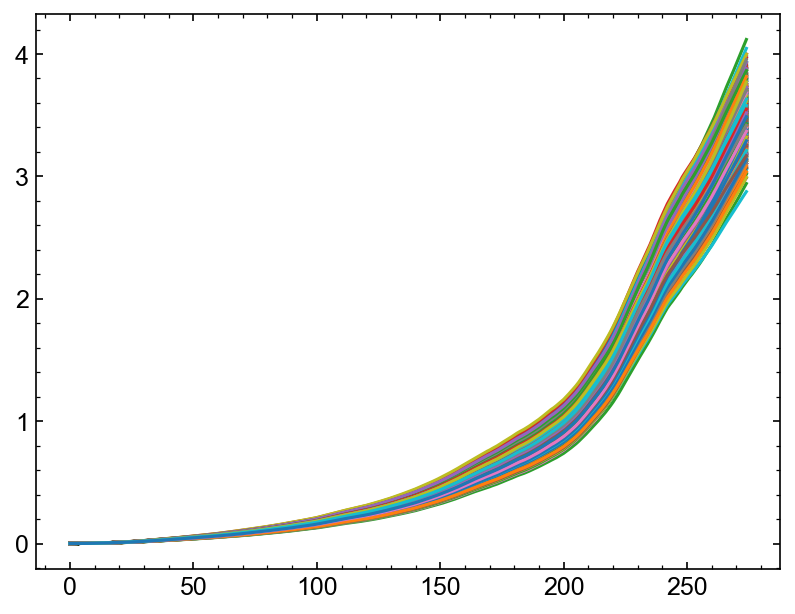

In [17]:
pl.plot(f.forcing.sel(specie=ghgs).sum(dim='specie').sel(scenario='all'));

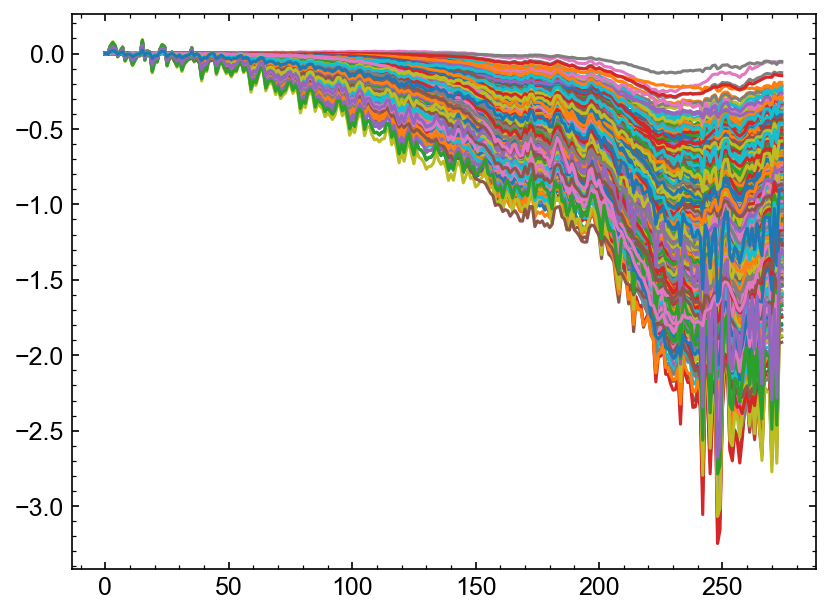

In [18]:
pl.plot(f.forcing.sel(specie=aerosols).sum(dim='specie').sel(scenario='all'));

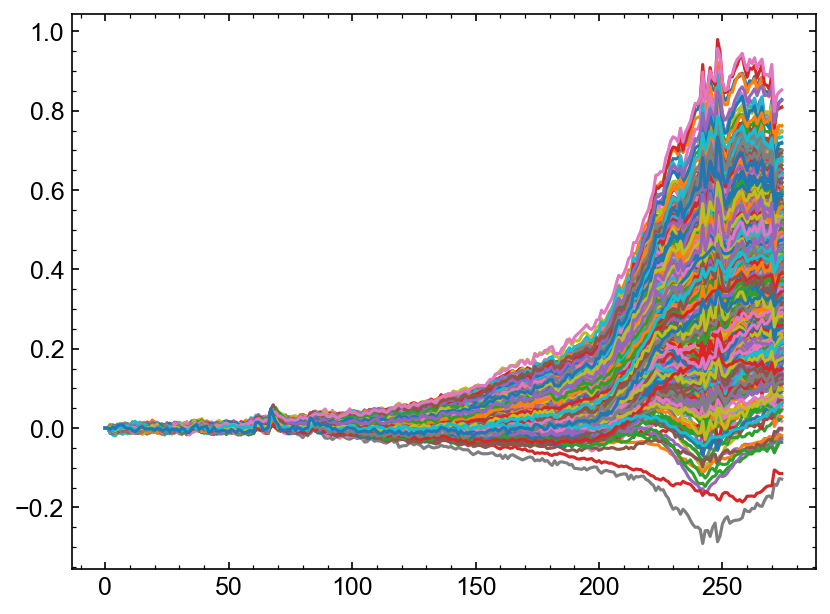

In [19]:
pl.plot(f.forcing.sel(specie=other).sum(dim='specie').sel(scenario='all'));

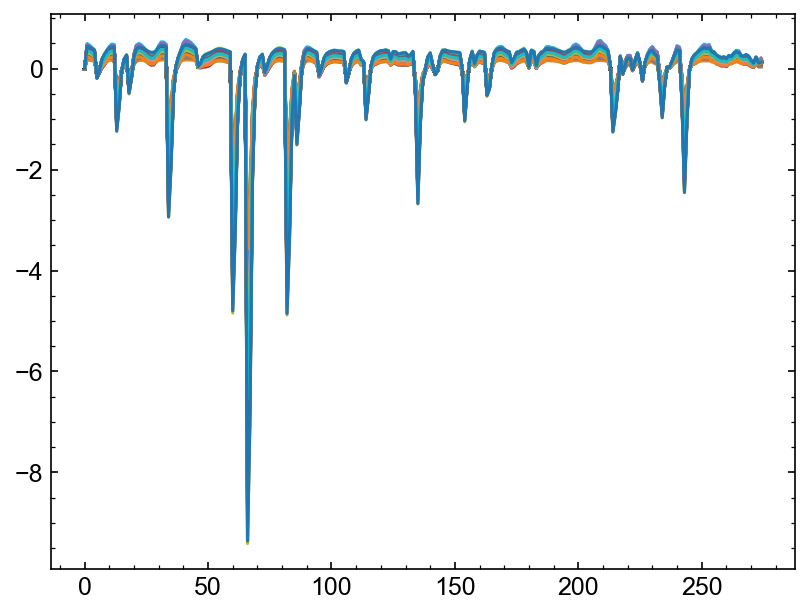

In [20]:
pl.plot(f.forcing.sel(specie=natural).sum(dim='specie').sel(scenario='all'));

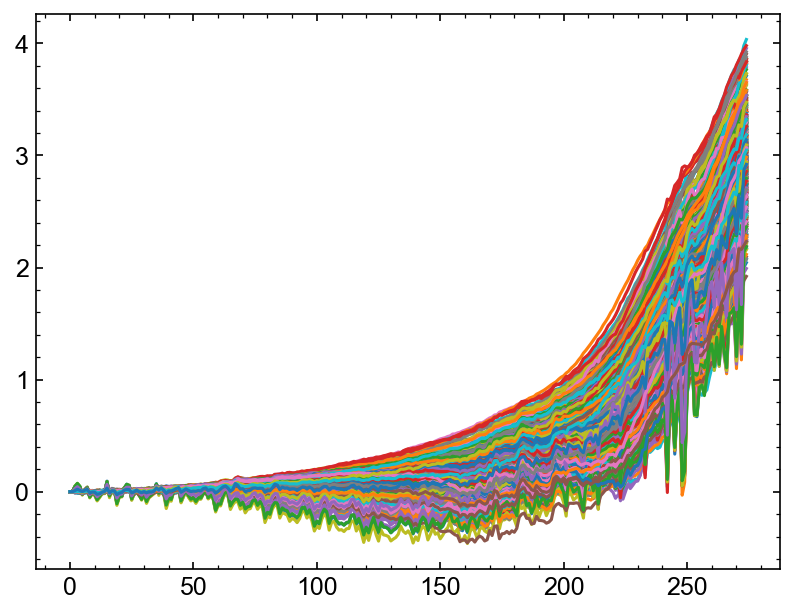

In [21]:
pl.plot(f.forcing.sel(specie=anthro).sum(dim='specie').sel(scenario='all'));

### Check linearity

note y-axis value very small - minimal floating point differences are fine

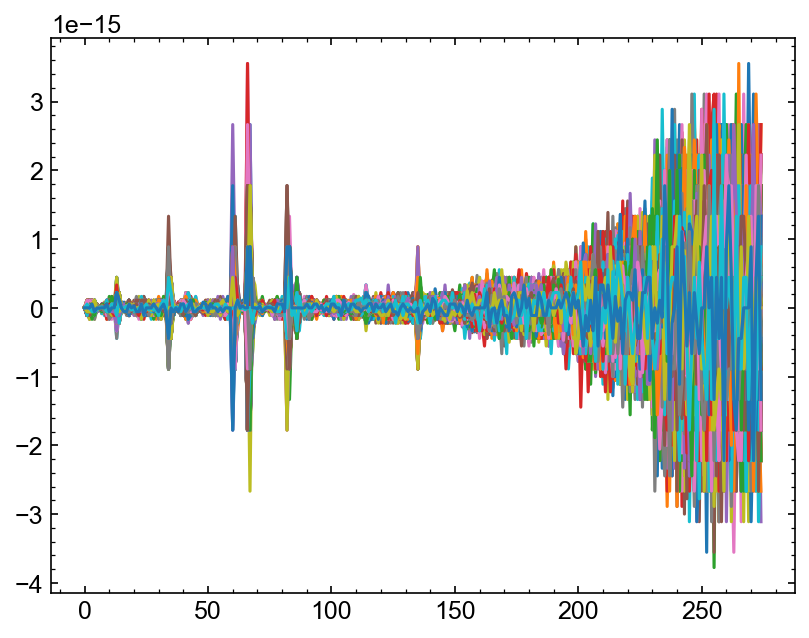

In [22]:
pl.plot(
    f.forcing_sum.sel(scenario='all') - (
        f.forcing.sel(specie=ghgs).sum(dim='specie').sel(scenario='all') +
        f.forcing.sel(specie=aerosols).sum(dim='specie').sel(scenario='all') +
        f.forcing.sel(specie=other).sum(dim='specie').sel(scenario='all') + 
        f.forcing.sel(specie=natural).sum(dim='specie').sel(scenario='all')
    )
);

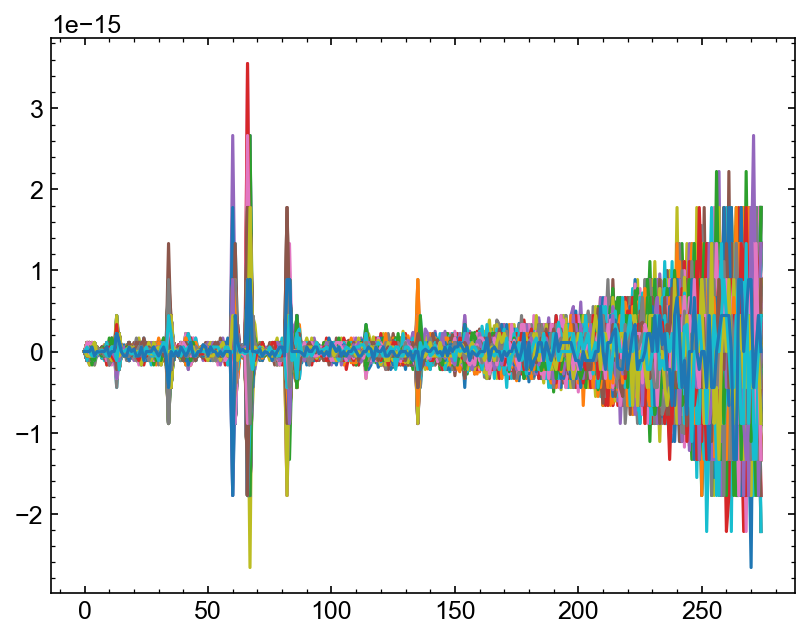

In [23]:
pl.plot(
    f.forcing_sum.sel(scenario='all') - (
        f.forcing.sel(specie=anthro).sum(dim='specie').sel(scenario='all') +
        f.forcing.sel(specie=natural).sum(dim='specie').sel(scenario='all')
    )
);

## Constrained ensemble statistics

Compare the constrained ensemble to the IPCC assessed ranges. ECS is asymmetric so we fit a skew-normal to the percentiles.

In [24]:
def opt(x, q05_desired, q50_desired, q95_desired):
    """Fit a skew-normal distribution to 5, 50, 95 percentiles.
    
    x is (a, loc, scale) in that order."""
    q05, q50, q95 = scipy.stats.skewnorm.ppf(
        (0.05, 0.50, 0.95), x[0], loc=x[1], scale=x[2]
    )
    return (q05 - q05_desired, q50 - q50_desired, q95 - q95_desired)

In [25]:
# conversion from one standard deviation to 90% range
NINETY_TO_ONESIGMA = scipy.stats.norm.ppf(0.95)
NINETY_TO_ONESIGMA

np.float64(1.6448536269514722)

In [26]:
ecs_params = scipy.optimize.root(opt, [1, 1, 1], args=(2, 3, 5)).x
ecs_params

array([8.82185594, 1.95059779, 1.55584604])

In [27]:
aer_dist = scipy.stats.norm(loc=-1.3, scale=0.7/NINETY_TO_ONESIGMA)

In [28]:
ecs_samp = ((df_configs['forcing_4co2']/2)/df_configs['ocean_heat_transfer[0]']).values
ecs_dist = scipy.stats.skewnorm(a=ecs_params[0], loc=ecs_params[1], scale=ecs_params[2])

In [29]:
aer_samp = f.forcing.sel(specie=aerosols, timebounds=np.arange(2005, 2015)).sum(dim='specie').sel(scenario='all').mean(dim='timebounds')

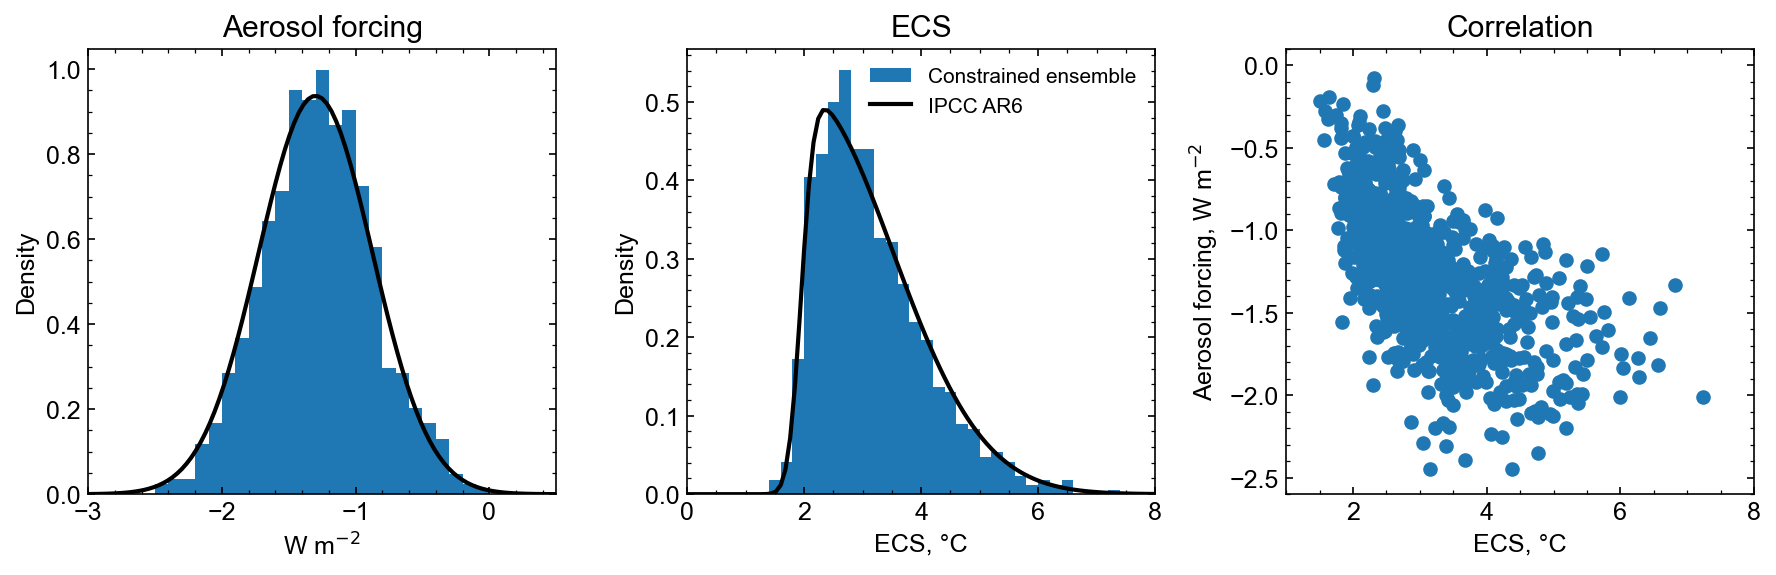

In [30]:
fig, ax = pl.subplots(1, 3, figsize=(12,4))

ax[0].hist(aer_samp, bins=np.arange(-2.5, 0.1, 0.1), density=True)
ax[0].plot(np.linspace(-3, 0.5, 101), aer_dist.pdf(np.linspace(-3, 0.5, 101)), color='k', lw=2)
ax[0].set_xlim(-3, 0.5)
ax[0].set_title('Aerosol forcing')
ax[0].set_xlabel('W m$^{-2}$')
ax[0].set_ylabel('Density')

ax[1].hist(ecs_samp, bins=np.arange(0, 8.1, 0.2), density=True, label='Constrained ensemble')
ax[1].plot(np.linspace(0, 8, 101), ecs_dist.pdf(np.linspace(0, 8, 101)), color='k', lw=2, label='IPCC AR6')
ax[1].set_xlim(0, 8)
ax[1].legend(fontsize=10, frameon=False)
ax[1].set_title('ECS')
ax[1].set_xlabel('ECS, °C')
ax[1].set_ylabel('Density')

ax[2].scatter(ecs_samp, aer_samp)
ax[2].set_xlim(1,8)
ax[2].set_ylim(-2.6, 0.1)
ax[2].set_title('Correlation')
ax[2].set_xlabel('ECS, °C')
ax[2].set_ylabel('Aerosol forcing, W m$^{-2}$')

fig.tight_layout()
os.makedirs('../plots/', exist_ok=True)
pl.savefig('../plots/distributions.png')

In [31]:
scenarios = ["all", "no_ghgs", "no_aerosols", "no_other", "no_natural", "no_anthro"]

In [32]:
ff = FAIR()
ff.define_time(1750, 2024, 1)
ff.define_scenarios(scenarios)
ff.define_configs(df_configs.index)

species = ["bulk"]
properties = {
    "bulk": {
        "type": "unspecified",
        "input_mode": "forcing",
        "greenhouse_gas": False,
        "aerosol_chemistry_from_emissions": False,
        "aerosol_chemistry_from_concentration": False,
    }
}

ff.define_species(species, properties)
ff.allocate()

### Create forcing-driven time series

In [33]:
fill(
    ff.forcing,
    f.forcing_sum.sel(scenario='all') - f.forcing.sel(specie=ghgs).sum(dim='specie').sel(scenario='all'),
    specie="bulk",
    scenario="no_ghgs"
)

In [34]:
fill(
    ff.forcing,
    f.forcing_sum.sel(scenario='all') - f.forcing.sel(specie=aerosols).sum(dim='specie').sel(scenario='all'),
    specie="bulk",
    scenario="no_aerosols"
)

In [35]:
fill(
    ff.forcing,
    f.forcing_sum.sel(scenario='all') - f.forcing.sel(specie=other).sum(dim='specie').sel(scenario='all'),
    specie="bulk",
    scenario="no_other"
)

In [36]:
fill(
    ff.forcing,
    f.forcing_sum.sel(scenario='all') - f.forcing.sel(specie=natural).sum(dim='specie').sel(scenario='all'),
    specie="bulk",
    scenario="no_natural"
)

In [37]:
fill(
    ff.forcing,
    f.forcing_sum.sel(scenario='all') - f.forcing.sel(specie=anthro).sum(dim='specie').sel(scenario='all'),
    specie="bulk",
    scenario="no_anthro"
)

In [38]:
fill(
    ff.forcing,
    f.forcing_sum.sel(scenario='all'),
    specie="bulk",
    scenario="all"
)

### fill and initialise configs

In [39]:
# climate response
ff.override_defaults("../data/calibration/v1.4.1/calibrated_constrained_parameters_1.4.1.csv")

# initial conditions
initialise(ff.forcing, 0)
initialise(ff.temperature, 0)
initialise(ff.ocean_heat_content_change, 0)

In [40]:
ff.run()

Running 5046 projections in parallel:   0%|          | 0/274 [00:00<?, ?timesteps/s]

In [41]:
base = np.arange(1850, 1901)
temp_ghgs = (
    (
        ff.temperature.sel(scenario="all", layer=0) - ff.temperature.sel(scenario="all", layer=0, timebounds=base).mean(dim='timebounds')
    ) - (
        ff.temperature.sel(scenario="no_ghgs", layer=0) - ff.temperature.sel(scenario="no_ghgs", layer=0, timebounds=base).mean(dim='timebounds')
    )
)
temp_aerosols = (
    (
        ff.temperature.sel(scenario="all", layer=0) - ff.temperature.sel(scenario="all", layer=0, timebounds=base).mean(dim='timebounds')
    ) - (
        ff.temperature.sel(scenario="no_aerosols", layer=0) - ff.temperature.sel(scenario="no_aerosols", layer=0, timebounds=base).mean(dim='timebounds')
    )
)
temp_natural = (
    (
        ff.temperature.sel(scenario="all", layer=0) - ff.temperature.sel(scenario="all", layer=0, timebounds=base).mean(dim='timebounds')
    ) - (
        ff.temperature.sel(scenario="no_natural", layer=0) - ff.temperature.sel(scenario="no_natural", layer=0, timebounds=base).mean(dim='timebounds')
    )
)
temp_other = (
    (
        ff.temperature.sel(scenario="all", layer=0) - ff.temperature.sel(scenario="all", layer=0, timebounds=base).mean(dim='timebounds')
    ) - (
        ff.temperature.sel(scenario="no_other", layer=0) - ff.temperature.sel(scenario="no_other", layer=0, timebounds=base).mean(dim='timebounds')
    )
)
temp_anthro = (
    (
        ff.temperature.sel(scenario="all", layer=0) - ff.temperature.sel(scenario="all", layer=0, timebounds=base).mean(dim='timebounds')
    ) - (
        ff.temperature.sel(scenario="no_anthro", layer=0) - ff.temperature.sel(scenario="no_anthro", layer=0, timebounds=base).mean(dim='timebounds')
    )
)
temp_all = ff.temperature.sel(scenario="all", layer=0) - ff.temperature.sel(scenario="all", layer=0, timebounds=base).mean(dim='timebounds')

In [42]:
df_obs = pd.read_csv('../data/observations/IGCC_GMST_1850-2023.csv', index_col=0)
df_obs

,gmst
year,
1850.5,-0.060196
1851.5,0.057304
1852.5,0.094804
1853.5,0.052304
1854.5,0.062304
...,...
2019.5,1.234804
2020.5,1.264804
2021.5,1.109804


## Gillett et al. (2021) style plot

fig 1 b in https://www.nature.com/articles/s41558-020-00965-9

Note the ranges coming out of fair are much more constrained than CMIP6 models in Gillett et al., since the historical climate record and emergent climate metrics are constrained on observations and AR6 assessment (by the fair-calibrate ensemble).

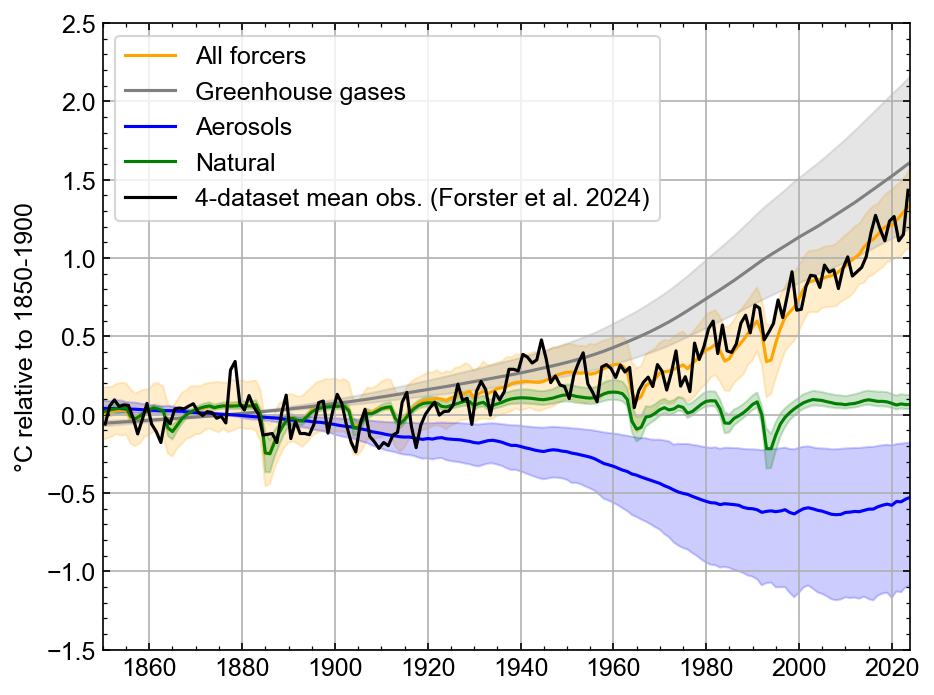

In [43]:
pl.fill_between(np.arange(1750, 2025), temp_all.quantile(0.05, dim="config"), temp_all.quantile(0.95, dim="config"), color='orange', alpha=0.2, lw=1)
pl.plot(np.arange(1750, 2025), temp_all.median(dim="config"), color='orange', label='All forcers');

pl.fill_between(np.arange(1750, 2025), temp_ghgs.quantile(0.05, dim="config"), temp_ghgs.quantile(0.95, dim="config"), color='0.5', alpha=0.2, lw=1)
pl.plot(np.arange(1750, 2025), temp_ghgs.median(dim="config"), color='0.5', label='Greenhouse gases');

pl.fill_between(np.arange(1750, 2025), temp_aerosols.quantile(0.05, dim="config"), temp_aerosols.quantile(0.95, dim="config"), color='blue', alpha=0.2, lw=1)
pl.plot(np.arange(1750, 2025), temp_aerosols.median(dim="config"), color='blue', label='Aerosols');

#pl.plot(np.arange(1750, 2024), temp_other.median(dim="config"), color='green')

pl.fill_between(np.arange(1750, 2025), temp_natural.quantile(0.05, dim="config"), temp_natural.quantile(0.95, dim="config"), color='green', alpha=0.2, lw=1)
pl.plot(np.arange(1750, 2025), temp_natural.median(dim="config"), color='green', label='Natural');
pl.plot(df_obs.gmst, color='k', label='4-dataset mean obs. (Forster et al. 2024)')

pl.ylabel('°C relative to 1850-1900')
pl.legend();
pl.grid()

pl.xlim(1850, 2024)
pl.ylim(-1.5, 2.5)

os.makedirs('../plots/', exist_ok=True)
pl.tight_layout()
pl.savefig('../plots/attributed_warming_rel1850-1900.png')

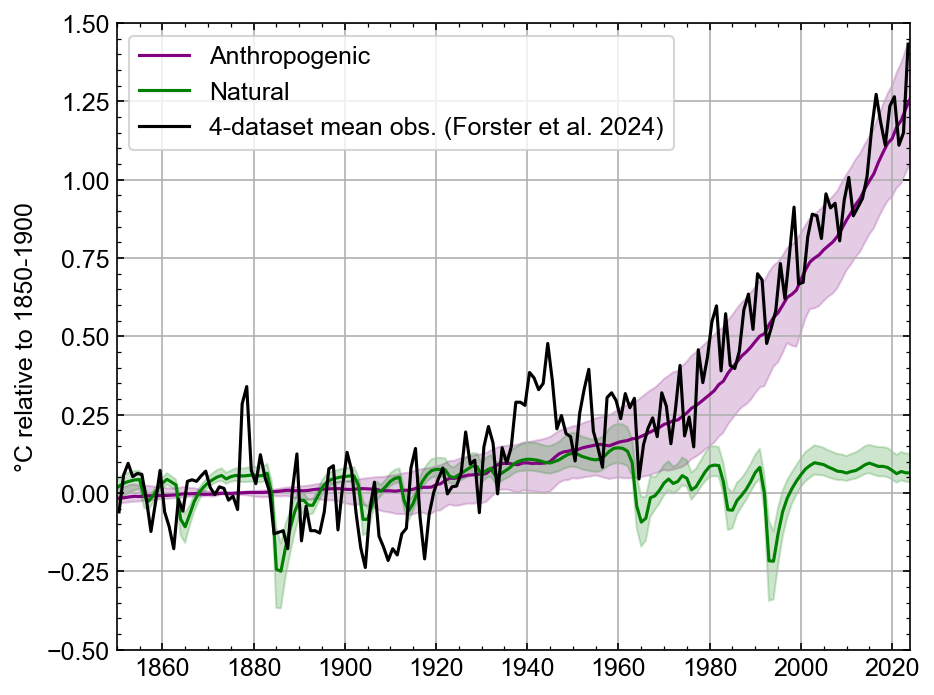

In [44]:
pl.fill_between(np.arange(1750, 2025), temp_anthro.quantile(0.05, dim="config"), temp_anthro.quantile(0.95, dim="config"), color='purple', alpha=0.2, lw=1)
pl.plot(np.arange(1750, 2025), temp_anthro.median(dim="config"), color='purple', label='Anthropogenic');

pl.fill_between(np.arange(1750, 2025), temp_natural.quantile(0.05, dim="config"), temp_natural.quantile(0.95, dim="config"), color='green', alpha=0.2, lw=1)
pl.plot(np.arange(1750, 2025), temp_natural.median(dim="config"), color='green', label='Natural');
pl.plot(df_obs.gmst, color='k', label='4-dataset mean obs. (Forster et al. 2024)')

pl.ylabel('°C relative to 1850-1900')
pl.legend();
pl.grid()

pl.xlim(1850, 2024)
pl.ylim(-0.5, 1.5)

os.makedirs('../plots/', exist_ok=True)
pl.tight_layout()
pl.savefig('../plots/attributed_warming_anth_nat_rel1850-1900.png')

In [45]:
temp_aerosols.median(dim="config")

<xarray.DataArray (timebounds: 275)> Size: 2kB
array([ 0.07666055,  0.07666055,  0.07717233,  0.07787373,  0.07813027,
        0.07766258,  0.07727525,  0.07758084,  0.07629   ,  0.0760887 ,
        0.07600272,  0.07514094,  0.07485003,  0.07529408,  0.07543064,
        0.07679452,  0.07602513,  0.07609302,  0.07621292,  0.07409588,
        0.0739659 ,  0.07402121,  0.07521053,  0.0763316 ,  0.07675087,
        0.07507139,  0.07467696,  0.07547128,  0.07478804,  0.07353988,
        0.07405419,  0.07253615,  0.07262017,  0.07310253,  0.07375274,
        0.07436994,  0.07406942,  0.07423052,  0.07357015,  0.07105091,
        0.07111483,  0.07076818,  0.07186358,  0.07258965,  0.07301449,
        0.07127433,  0.07124075,  0.07212019,  0.07121473,  0.0704096 ,
        0.07029355,  0.06947127,  0.06955799,  0.06929403,  0.06986743,
        0.07055636,  0.06985481,  0.06965003,  0.06874436,  0.06687973,
        0.06638429,  0.06561673,  0.06623121,  0.06698513,  0.06733397,
        0.06545695,  0.06463863,  0.06463399,  0.06410218,  0.06302748,
        0.06274903,  0.06139864,  0.06099249,  0.06100322,  0.06144742,
        0.06208605,  0.06081102,  0.06074832,  0.06003714,  0.05678596,
        0.05620551,  0.05502196,  0.05579522,  0.05674128,  0.05682811,
        0.05419939,  0.05372706,  0.05305083,  0.05181137,  0.04998348,
        0.04934997,  0.04864188,  0.04695446,  0.04660882,  0.04798718,
        0.04809794,  0.04656637,  0.04610872,  0.04387784,  0.04093628,
...
       -0.15644782, -0.15832238, -0.16039036, -0.16598269, -0.17025621,
       -0.17808661, -0.18097198, -0.17296279, -0.16563464, -0.16334676,
       -0.16873453, -0.17593853, -0.18683866, -0.19612113, -0.19581477,
       -0.20260051, -0.21100073, -0.21738271, -0.22562186, -0.23136102,
       -0.23491248, -0.22815633, -0.22382201, -0.22657845, -0.2327362 ,
       -0.23614036, -0.24501023, -0.25002994, -0.2564826 , -0.26350927,
       -0.27099072, -0.28171216, -0.29679246, -0.31197051, -0.32003195,
       -0.32916726, -0.34175993, -0.35376374, -0.3624691 , -0.37840946,
       -0.38576844, -0.39800081, -0.40818013, -0.41806855, -0.4286012 ,
       -0.4384427 , -0.45345938, -0.46488697, -0.47997424, -0.49357646,
       -0.50185564, -0.50848557, -0.52088951, -0.53189506, -0.54321694,
       -0.55308259, -0.56171183, -0.563716  , -0.57404983, -0.56810456,
       -0.57113651, -0.57390718, -0.57806912, -0.59131878, -0.5984703 ,
       -0.6000974 , -0.6069662 , -0.62335082, -0.61679297, -0.6139268 ,
       -0.61901246, -0.61458457, -0.60665204, -0.62393406, -0.63313248,
       -0.61510626, -0.59983373, -0.59403829, -0.60081363, -0.61017374,
       -0.6156515 , -0.62589223, -0.63539785, -0.63833813, -0.63636794,
       -0.62411937, -0.6220587 , -0.61735191, -0.61902896, -0.61127227,
       -0.60294779, -0.60254354, -0.58776352, -0.57783734, -0.57104219,
       -0.57800647, -0.55442654, -0.55580921, -0.53879086, -0.52715494])
Coordinates:
  * timebounds  (timebounds) float64 2kB 1.75e+03 1.751e+03 ... 2.024e+03
    layer       int64 8B 0

In [46]:
df_out = pd.DataFrame(
    np.array(
        [
            temp_ghgs.quantile(0.05, dim="config").data,
            temp_ghgs.median(dim="config").data,
            temp_ghgs.quantile(0.95, dim="config").data,
            temp_aerosols.quantile(0.05, dim="config").data,
            temp_aerosols.median(dim="config").data,
            temp_aerosols.quantile(0.95, dim="config").data,
            temp_other.quantile(0.05, dim="config").data,
            temp_other.median(dim="config").data,
            temp_other.quantile(0.95, dim="config").data,
            temp_natural.quantile(0.05, dim="config").data,
            temp_natural.median(dim="config").data,
            temp_natural.quantile(0.95, dim="config").data,
            temp_anthro.quantile(0.05, dim="config").data,
            temp_anthro.median(dim="config").data,
            temp_anthro.quantile(0.95, dim="config").data,
            temp_all.quantile(0.05, dim="config").data,
            temp_all.median(dim="config").data,
            temp_all.quantile(0.95, dim="config").data,
        ]
    ).T,
    index=np.arange(1750, 2025),
    columns=['ghg_05', 'ghg_50', 'ghg_95', 'aerosol_05', 'aerosol_50', 'aerosol_95', 'other_05', 'other_50', 'other_95', 'natural_05', 'natural_50', 'natural_95', 'anthro_05', 'anthro_50', 'anthro_95', 'all_05', 'all_50', 'all_95']
)

In [47]:
os.makedirs('../output', exist_ok=True)
df_out.to_csv('../output/attributed_warming.csv')